In [2]:
import sys
sys.path.append("../")

import jax
import jax.numpy as np

import optax 
from flax.training import checkpoints, common_utils, train_state
import flax
import orbax.checkpoint as ocp
from utils.dataset_utils import make_dataloader, create_input_iter
import tensorflow as tf
from tqdm import tqdm

from transformers import FlaxCLIPModel, AutoProcessor, AutoTokenizer

import yaml
from ml_collections.config_dict import ConfigDict

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

In [3]:

logging_dir = '/n/holystore01/LABS/iaifi_lab/Users/smsharma/multimodal-data/logging/proposals/'
run_name = 'glistening-kumquat-123'  # Fine tune with summaries

config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-4,
    warmup_steps=5_000,
    decay_steps=100_000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-4)
state = train_state.TrainState.create(apply_fn=model.__call__, params=model.params, tx=tx)

In [4]:
ckpt_dir = "{}/{}".format(logging_dir, run_name)  # Load SLURM run

best_fn = lambda metrics: metrics[f"val/top_10_accuracy"]

mgr_options = ocp.CheckpointManagerOptions(step_prefix=f'step', best_fn=best_fn, best_mode='min', create=False)

ckpt_mgr_load_ckpt = ocp.CheckpointManager(
    f"{ckpt_dir}/ckpts/",
    options=mgr_options,
)

restored_state = ckpt_mgr_load_ckpt.restore(
    ckpt_mgr_load_ckpt.latest_step(),
    args=ocp.args.StandardRestore(state)
)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

In [19]:
! ls /n/holyscratch01/iaifi_lab/smsharma/hubble_data/tfrecords_v5/

In [11]:
files = tf.io.gfile.glob(f"/n/holyscratch01/iaifi_lab/smsharma/hubble_data/tfrecords_v5/*val*.tfrecord")

ds = make_dataloader(files, batch_size=32, seed=42, split="val", shuffle=False, caption_type="summary")
batches = iter(ds)

In [12]:
from dm_pix import center_crop

In [13]:
def cosine_similarity(vec1, vec2):
    
    norm_vec1 = np.linalg.norm(vec1, axis=-1, keepdims=True)
    norm_vec2 = np.linalg.norm(vec2, axis=-1, keepdims=True)

    vec1 /= norm_vec1
    vec2 /= norm_vec2
        
    return np.dot(vec1, vec2)

## Text-to-image retrieval

In [14]:
image_feat_stack = []
images_stack = []
captions_stack = []

for (images, captions) in tqdm(batches, total=100):

    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]
    captions_stack += captions

    images_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)
    
    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=restored_state.params);
    image_feat_stack.append(image_feat)

  0%|          | 0/100 [00:00<?, ?it/s]


In [20]:
import pandas as pd

df_sum_merged = pd.read_csv("../data/summary_v2.csv")

def get_propid_phenomena(caption):
    first_part = caption.split(";")[0]
    match = df_sum_merged[df_sum_merged["objects_phenomena"] == first_part][
        "proposal_id"
    ]
    return (
        match.values[0] if not (match.empty or pd.isna(match.values[0])) else "None"
    )

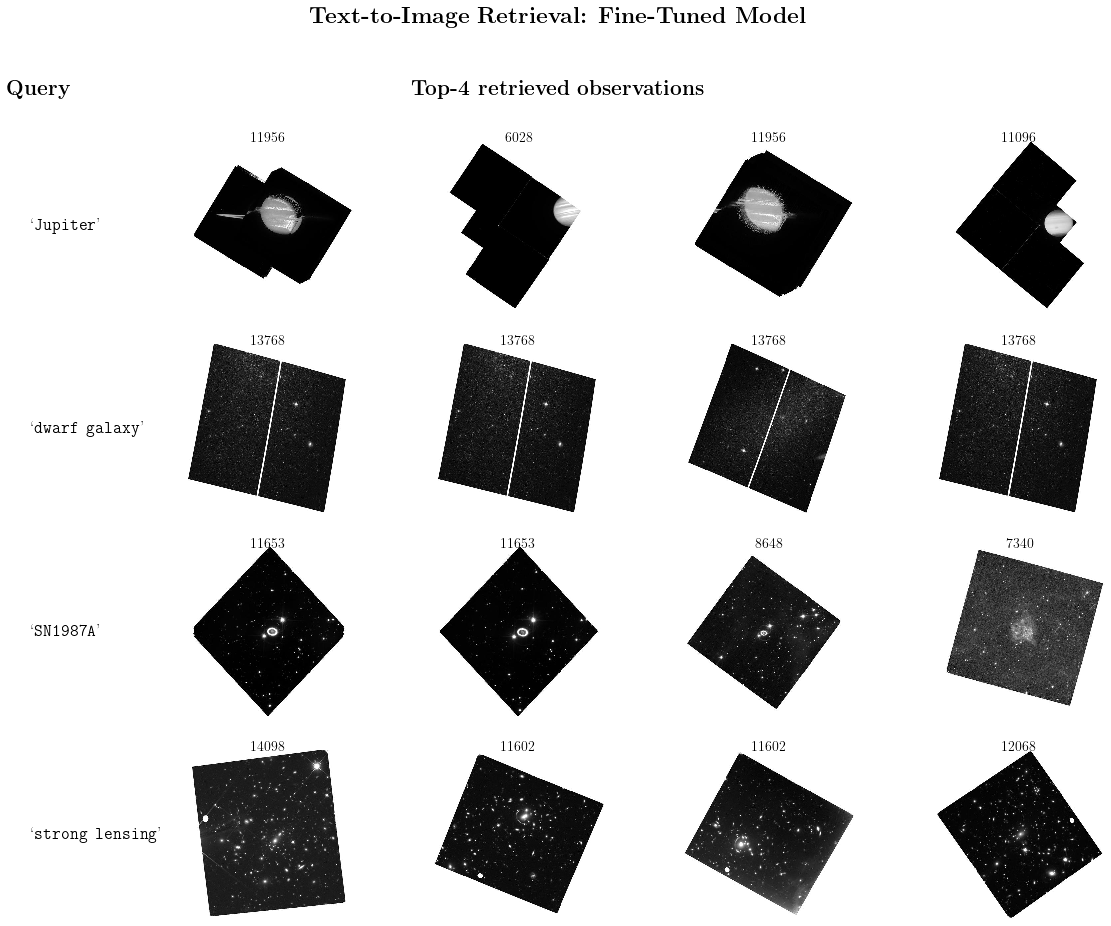

In [21]:
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib import rc
import matplotlib

rc("text", usetex=True)
rc("text.latex", preamble=r"\usepackage{color}")
rc("text.latex", preamble=r"\usepackage{xcolor}")

# Assuming 'tokenizer', 'model', 'image_feat_stack', 'config', and 'cosine_similarity' are already defined

def get_image_from_stack(images_stack, idx):
    return images_stack[idx // config.training.batch_size][idx % config.training.batch_size]

# List of text queries
# queries = ["globular clusters", "dwarf galaxy", "SN1987A", "cluster lensing"] 
queries = ["Jupiter", "dwarf galaxy", "SN1987A", "strong lensing"] 

# Number of columns for the images
m_cols = 4  # Change this as needed

# Create figure with specified size
fig = plt.figure(figsize=(16, 18 * len(queries) / 5.))

# Add a main title, make "fine-tuned model" in red color font
plt.suptitle(r"\textbf{Text-to-Image Retrieval: \textcolor{red}{Fine-Tuned Model}}", fontsize=23, fontweight='bold')

axes_list = []
sorted_idxs_list = []

# Process each query
for row, query in enumerate(queries):
    query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")
    text_feat = model.get_text_features(**query_tokenized, params=restored_state.params)
    sorted_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_feat_stack), text_feat[0]))[::-1]

    sorted_idxs_list.append(sorted_idxs)

    # Loop through the images for this query and plot them
    for col in range(m_cols):
        idx = sorted_idxs[col]
        ax = plt.subplot(len(queries), m_cols, row * m_cols + col + 1)
        ax.imshow(get_image_from_stack(images_stack, idx))
        ax.axis('off')

        axes_list.append(ax)

        # Add text string "9999" above the image
        plt.text(0.5, 1.02, f"{get_propid_phenomena(captions_stack[idx])}", transform=ax.transAxes, fontsize=14, ha='center', va='center')

        # Add the query name to the left of the first column
        if col == 0:
            # plt.text(-0.1, 0.5, r"`\texttt{" + query + "}'", transform=ax.transAxes, fontsize=16, rotation=90, va='center', ha='right', fontfamily='monospace')
            plt.text(-0.9, 0.5, r"`\texttt{" + query + "}'", transform=ax.transAxes, fontsize=17, rotation=0, va='center', ha='left', fontfamily='monospace')    
        
# Adding labels for "Query" and "Most similar images"
# The coordinates here might need adjustment depending on your figure layout
fig.text(0.05, 0.9, r"\textbf{Query}", fontsize=21, ha='center', va='center')
fig.text(0.5, 0.9, r"\textbf{Top-4 retrieved observations}", fontsize=21, ha='center', va='center')

plt.subplots_adjust(left=0.15, right=1, top=0.85, bottom=0.1, wspace=0.1, hspace=0.2)

# plt.tight_layout()
# plt.savefig("../paper/plots/tti.pdf", dpi=500)
# plt.savefig("../paper/plots/tti_abs.pdf", dpi=500)


In [19]:
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib import rc
import matplotlib

rc("text", usetex=True)
rc("text.latex", preamble=r"\usepackage{color}")
rc("text.latex", preamble=r"\usepackage{xcolor}")

# Assuming 'tokenizer', 'model', 'image_feat_stack', 'config', and 'cosine_similarity' are already defined

def get_image_from_stack(images_stack, idx):
    return images_stack[idx // config.training.batch_size][idx % config.training.batch_size]

# List of text queries
# queries = ["globular clusters", "dwarf galaxy", "SN1987A", "cluster lensing"] 
queries = ["Jupiter", "dwarf galaxy", "SN1987A", "strong lensing"] 

# Number of columns for the images
m_cols = 4  # Change this as needed

sorted_idxs_list = []

save_dir = "../paper/plots/data/"

# Process each query
for row, query in enumerate(queries):
    query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")
    text_feat = model.get_text_features(**query_tokenized, params=restored_state.params)
    sorted_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_feat_stack), text_feat[0]))[::-1]

    sorted_idxs_list.append(sorted_idxs)

    with open(save_dir + f"/query_tti_{row}.txt", 'w') as file:
        file.write(query)

    # Loop through the images for this query and plot them
    for col in range(m_cols):

        idx = sorted_idxs[col]

        plt.figure(figsize=(8,8))
        plt.imshow(get_image_from_stack(images_stack, idx))
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(save_dir + f"/img_tti_{row}_{col}.pdf")
        plt.close()

        with open(save_dir + f"/propid_tti_{row}_{col}.txt", 'w') as file:
            idy = str(get_propid_phenomena(captions_stack[idx]))
            url = f"\\href{{https://archive.stsci.edu/proposal_search.php?id={idy}&mission=hst}}{{{idy}}}"
            file.write(url)

In [20]:
[captions_stack[idx] for idx in sorted_idxs_list[0]][:4]

['spiral galaxies, star-forming regions, supernovae, protoplanetary disks, Seyfert galaxies; study stellar populations in spiral galaxies, analyze star formation processes in nebulae, measure supernova properties, investigate protoplanetary disk physics, examine active galactic nuclei in Seyfert galaxies',
 'Io, polar regions, Pele volcano, sulfur dioxide, sodium sulfide; determine surface composition and spatial distribution, analyze polar region compositions, investigate the nature of Pele volcano deposits',
 'spiral galaxies, star-forming regions, supernovae, protoplanetary disks, Seyfert galaxies; study stellar populations in spiral galaxies, analyze star formation processes in nebulae, measure supernova properties, investigate protoplanetary disk physics, examine active galactic nuclei in Seyfert galaxies',
 "Jupiter, Jupiter's atmospheric features; study Jupiter's atmospheric dynamics, support New Horizons flyby of Jupiter"]

## Base model

In [39]:
batches = iter(ds)

In [40]:
import jax

image_base_feat_stack = []
images_base_stack = []
captions_base_stack = []

for (images, captions) in tqdm(batches, total=100):

    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]
    captions_base_stack += captions

    images_base_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)
    
    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=state.params);
    image_base_feat_stack.append(image_feat)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [04:28<00:00,  2.68s/it]


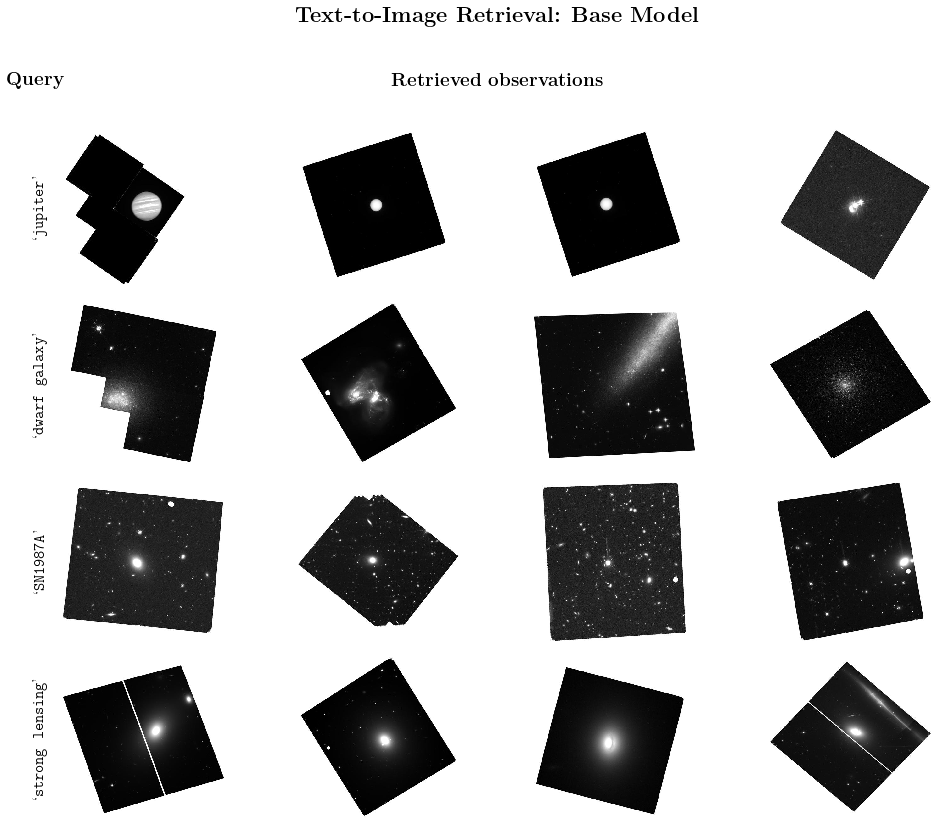

In [41]:
# Assuming 'tokenizer', 'model', 'image_feat_stack', 'config', and 'cosine_similarity' are already defined

def get_image_from_stack(images_stack, idx):
    return images_stack[idx // config.training.batch_size][idx % config.training.batch_size]

# List of text queries
queries = ["jupiter", "dwarf galaxy", "SN1987A", "strong lensing"] 

# Number of columns for the images
m_cols = 4  # Change this as needed

# Create figure with specified size
fig = plt.figure(figsize=(16, 16 * len(queries) / 5.))

# Add a main title
plt.suptitle(r"\textbf{Text-to-Image Retrieval: Base Model}", fontsize=22, fontweight='bold')

axes_list = []

# Process each query
for row, query in enumerate(queries):
    query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")
    text_feat = model.get_text_features(**query_tokenized, params=state.params)
    sorted_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_base_feat_stack), text_feat[0]))[::-1]

    # Loop through the images for this query and plot them
    for col in range(m_cols):
        idx = sorted_idxs[col]
        ax = plt.subplot(len(queries), m_cols, row * m_cols + col + 1)
        ax.imshow(get_image_from_stack(images_base_stack, idx))
        ax.axis('off')

        axes_list.append(ax)

        # Add the query name to the left of the first column
        if col == 0:
            plt.text(-0.1, 0.5, r"`\texttt{" + query + "}'", transform=ax.transAxes, fontsize=16, rotation=90, va='center', ha='right', fontfamily='monospace')

# Adding labels for "Query" and "Most similar images"
# The coordinates here might need adjustment depending on your figure layout
fig.text(0.1, 0.9, r"\textbf{Query}", fontsize=19, ha='center', va='center')
fig.text(0.5, 0.9, r"\textbf{Retrieved observations}", fontsize=19, ha='center', va='center')

plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.1, wspace=0.1, hspace=0.1)
# plt.savefig("../paper/plots/tti_base.pdf", dpi=500)

In [43]:
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from matplotlib import rc
import matplotlib

rc("text", usetex=True)
rc("text.latex", preamble=r"\usepackage{color}")
rc("text.latex", preamble=r"\usepackage{xcolor}")

# Assuming 'tokenizer', 'model', 'image_feat_stack', 'config', and 'cosine_similarity' are already defined

def get_image_from_stack(images_stack, idx):
    return images_stack[idx // config.training.batch_size][idx % config.training.batch_size]

# List of text queries
# queries = ["globular clusters", "dwarf galaxy", "SN1987A", "cluster lensing"] 
queries = ["Jupiter", "dwarf galaxy", "SN1987A", "strong lensing"] 

# Number of columns for the images
m_cols = 4  # Change this as needed

sorted_idxs_list = []

save_dir = "../paper/plots/data/"

# Process each query
for row, query in enumerate(queries):
    query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")
    text_feat = model.get_text_features(**query_tokenized, params=state.params)
    sorted_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_base_feat_stack), text_feat[0]))[::-1]

    sorted_idxs_list.append(sorted_idxs)

    with open(save_dir + f"/query_tti_base_{row}.txt", 'w') as file:
        file.write(query)

    # Loop through the images for this query and plot them
    for col in range(m_cols):

        idx = sorted_idxs[col]

        plt.figure(figsize=(8,8))
        plt.imshow(get_image_from_stack(images_base_stack, idx))
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(save_dir + f"/img_tti_base_{row}_{col}.pdf")
        plt.close()

        with open(save_dir + f"/propid_tti_base_{row}_{col}.txt", 'w') as file:
            idy = str(get_propid_phenomena(captions_base_stack[idx]))
            url = f"\\href{{https://archive.stsci.edu/proposal_search.php?id={idy}&mission=hst}}{{{idy}}}"
            file.write(url)

## Zero-shot classification

In [44]:
cleaned2_sum1 = []
with open("../data/sum1_gpt4.txt", "r") as file:
    for line in file:
        cleaned2_sum1.append(line.strip())

In [52]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

hubble_observation_categories = ["star forming galaxies", "lyman alpha", "dust", "crowded stellar field", "core-collapse supernova", "cosmology", "gravitational lensing", "supernovae", "diffuse galaxies", "globular clusters", "stellar populations", "interstellar medium", "black holes", "dark matter", "galaxy clusters", "galaxy evolution", "galaxy formation", "quasars", "circumstellar disks", "exoplanets", "Kuiper Belt objects", "solar system objects", "cosmic web structure", "distant galaxies", "galaxy mergers", "galaxy interactions", "star formation", "stellar winds", "brown dwarfs", "white dwarfs", "nebulae", "star clusters", "galaxy archeology", "galactic structure", "active galactic nuclei", "gamma-ray bursts", "stellar nurseries", "intergalactic medium", "dark energy", "dwarf galaxies", "barred spiral galaxies", "irregular galaxies", "starburst galaxies", "LSBGs", "ultra diffuse galaxies", "circumgalactic medium", "intracluster medium", "cosmic dust", "interstellar chemistry", "star formation histories", "initial mass function", "stellar proper motions", "binary star systems", "open clusters", "pre-main sequence stars", "protostars", "protoplanetary disks", "jets and outflows", "interstellar shocks", "planetary nebulae", "supernova remnants", "red giants", "Cepheid variables", "RR Lyrae variables", "stellar abundances", "stellar dynamics", "compact stellar remnants", "Einstein rings", "trans-Neptunian objects", "cosmic microwave background", "reionization epoch", "first stars", "first galaxies", "high-redshift quasars", "primordial black holes", "resolved binaries", "binary stars"]

hubble_observation_categories_inputs = tokenizer(hubble_observation_categories, padding="max_length", truncation=True, max_length=77, return_tensors="np")

def display_content(image, paragraph, classes):
    # Create a figure and define the grid specification
    fig = plt.figure(figsize=(7, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 2])

    # Display the image on the left subplot (spanning all rows)
    ax0 = plt.subplot(gs[:, 0])
    ax0.imshow(image)
    ax0.axis('off')  # Turn off axis numbers and ticks

    # Display the list of classes on the right subplot (spanning all rows)
    ax2 = plt.subplot(gs[:, 1])
    # Add ranking numbers and the title "Top Classes"
    ranked_classes = [f"{i+1}. {cls}" for i, cls in enumerate(classes)]
    class_text = "Top Classes by Cos. Sim.:\n" + "\n".join(ranked_classes)
    ax2.text(0.5, 0.5, class_text, ha='center', va='center', bbox=dict(boxstyle="square,pad=0.3", facecolor="white", edgecolor="black"))
    ax2.axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()
    plt.show()

In [21]:
[sorted_idxs_list[i][0] for i in range(1, 4)] + [156]
# [2652, 230, 1744, 156]

[Array(2652, dtype=int32),
 Array(230, dtype=int32),
 Array(1744, dtype=int32),
 156]

Text(0.5, 1.02, '\\textbf{Image-to-Text Retrieval}')

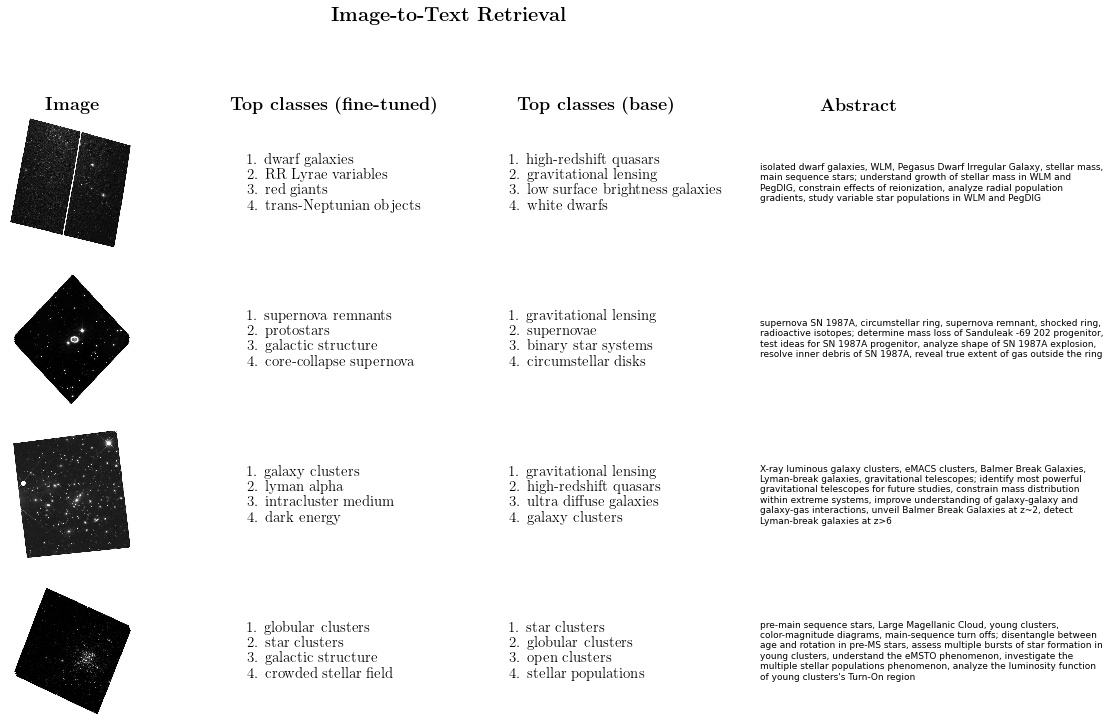

In [53]:
import matplotlib.pyplot as plt

# Assuming these functions and variables are already defined:
# model, inputs_images, claude_science_cat_inputs, restored_state, display_content, images, captions, claude_science_cat

indices = [sorted_idxs_list[i][0] for i in range(1, 4)] + [156]  # Replace with your list of indices
num_rows = len(indices)

# Adjust the figsize and width_ratios as needed
fig = plt.figure(figsize=(18, 11))  # Increased width for better layout
gs = gridspec.GridSpec(nrows=num_rows, ncols=4, width_ratios=[1, 1, 1, 1])


for row, idx in enumerate(indices):
    # Compute features, similarities, etc. as before

    image_feat = np.vstack(image_feat_stack)[idx]
    text_feat = model.get_text_features(**hubble_observation_categories_inputs, params=restored_state.params)
    
    cats = [hubble_observation_categories[i] for i in np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(text_feat, image_feat))[::-1]][:4]
    ranked_cats = [f"{i+1}. {cls}" for i, cls in enumerate(cats)]
    cats_text = "\n".join(ranked_cats)

    # Add image to the first column
    ax_img = fig.add_subplot(gs[row, 0])
    ax_img.imshow(get_image_from_stack(images_stack, idx))
    ax_img.axis('off')

    # Add science cases to the second column
    ax_science = fig.add_subplot(gs[row, 1])
    ax_science.text(0.1, 0.5, cats_text, va='center', ha='left', fontsize=15)
    ax_science.axis('off')

    image_feat = np.vstack(image_base_feat_stack)[idx]
    text_feat = model.get_text_features(**hubble_observation_categories_inputs, params=state.params)
    
    cats = [hubble_observation_categories[i] for i in np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(text_feat, image_feat))[::-1]][:4]
    ranked_cats = [f"{i+1}. {cls}" for i, cls in enumerate(cats)]
    cats_text = "\n".join(ranked_cats)

    # Add science cases to the second column
    ax_science2 = fig.add_subplot(gs[row, 2])
    ax_science2.text(0.1, 0.5, cats_text, va='center', ha='left', fontsize=15)
    ax_science2.axis('off')

    # Add true abstract to the fourth column
    ax_abstract = fig.add_subplot(gs[row, 3])
    # Adjust the x-position and width of the text for better wrapping
    ax_abstract.text(0.05, 0.5, captions_stack[idx], va='center', ha='left',fontsize=9, wrap=True, usetex=False)
    ax_abstract.axis('off')

    if row == 0:
        ax_img.set_title(r"\textbf{Image}")
        ax_science.set_title(r"\textbf{Top classes (fine-tuned)}")
        ax_science2.set_title(r"\textbf{Top classes (base)}")
        ax_abstract.set_title(r"\textbf{Abstract}")

# Add a general title for the whole figure (optional)
fig.suptitle(r'\textbf{Image-to-Text Retrieval}', fontsize=20, y=1.02)

# Adjust layout and display the plot
# plt.tight_layout()
# plt.savefig("../paper/plots/itt_abs.pdf", bbox_inches='tight', dpi=500)

In [54]:
import matplotlib.pyplot as plt

# Assuming these functions and variables are already defined:
# model, inputs_images, claude_science_cat_inputs, restored_state, display_content, images, captions, claude_science_cat

indices = [sorted_idxs_list[i][0] for i in range(1, 4)] + [156]  # Replace with your list of indices
num_rows = len(indices)

for row, idx in enumerate(indices):
    # Compute features, similarities, etc. as before
    
    plt.figure(figsize=(8,8))
    plt.imshow(get_image_from_stack(images_stack, idx))
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_dir + f"/img_itt_{row}.pdf")
    plt.close()

    # FT model

    image_feat = np.vstack(image_feat_stack)[idx]
    text_feat = model.get_text_features(**hubble_observation_categories_inputs, params=restored_state.params)
    
    cats = [hubble_observation_categories[i] for i in np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(text_feat, image_feat))[::-1]][:4]
    ranked_cats = [f"{i+1}. {cls}" for i, cls in enumerate(cats)]
    cats_text = "\n".join(ranked_cats)

    # Write to file
    with open(save_dir + f"/sci_itt_{row}.txt", 'w') as file:
        file.write(cats_text)

    # Base model

    image_feat = np.vstack(image_base_feat_stack)[idx]
    text_feat = model.get_text_features(**hubble_observation_categories_inputs, params=state.params)
    
    cats = [hubble_observation_categories[i] for i in np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(text_feat, image_feat))[::-1]][:4]
    ranked_cats = [f"{i+1}. {cls}" for i, cls in enumerate(cats)]
    cats_text = "\n".join(ranked_cats)

    # Write to file
    with open(save_dir + f"/sci_itt_base_{row}.txt", 'w') as file:
        file.write(cats_text)
    
    # Write abstract to file
    with open(save_dir + f"/abs_itt_{row}.txt", 'w') as file:
        # Only extract part before first semicolon
        file.write(captions_stack[idx].split(";")[0])

## Viz embeddings

In [21]:
import jax.numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [296]:
X = np.vstack(image_feat_stack)[:6000]
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)

In [22]:
pca = PCA(n_components=2)
X_embedded = pca.fit_transform(np.vstack(image_feat_stack)[:])

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_embedded)

100%|██████████| 2000/2000 [00:04<00:00, 499.49it/s]


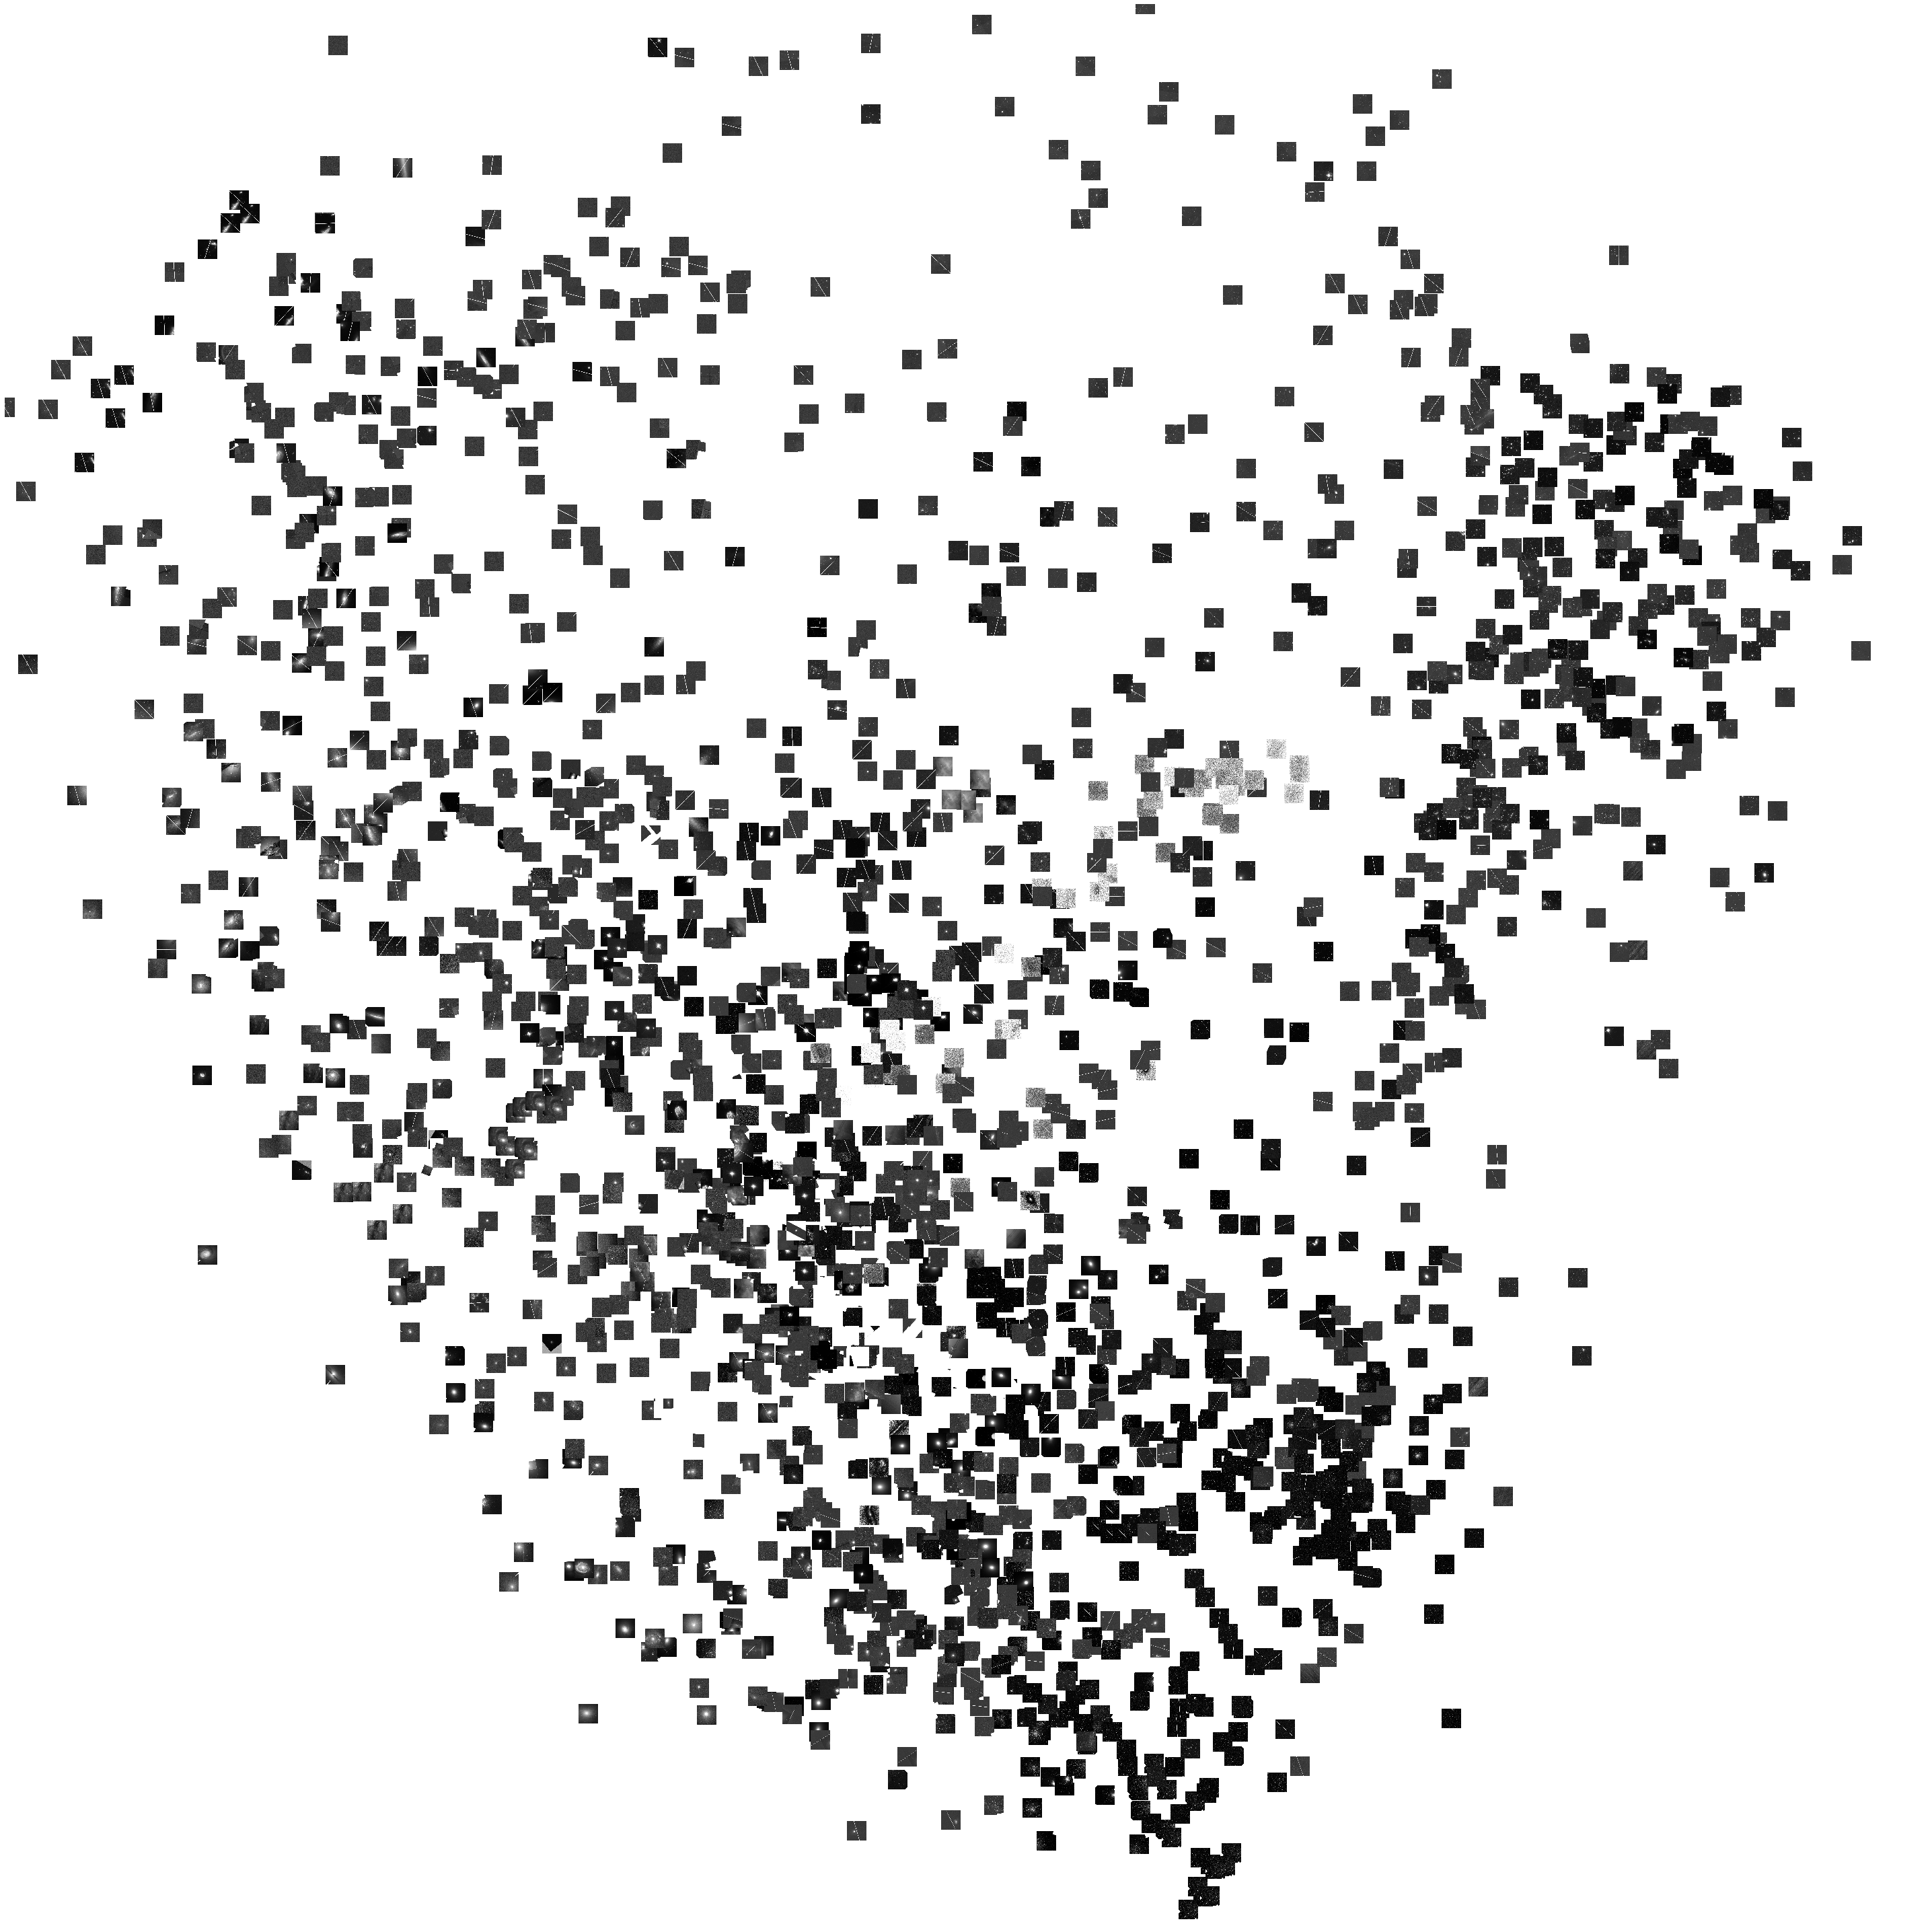

In [24]:
from matplotlib import offsetbox

dx = 0.005

fig, ax = plt.subplots(figsize=(40,40))
for idx in tqdm(range(2000)):
    x, y = X_scaled[idx, 0], X_scaled[idx, 1]
    ax.imshow(center_crop(get_image_from_stack(images_stack, idx), 224, 224), extent=[x - dx, x + dx, y - dx, y + dx])

ax.axis('off')  # Optionally turn off the axis

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("../paper/plots/pca.pdf", dpi=500)

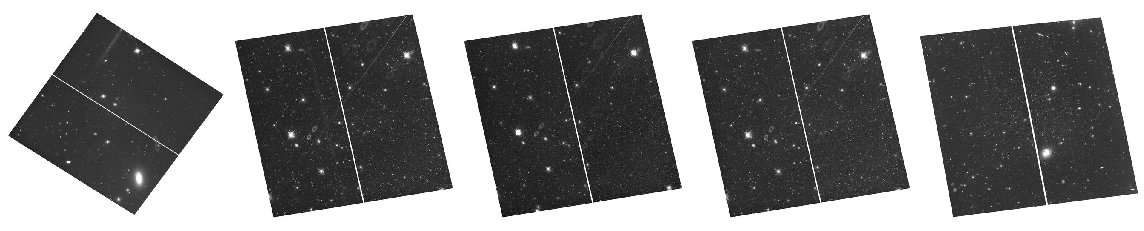

In [205]:
# text_query = "barrred spiral galaxy"
# text_query_tokenized = tokenizer([text_query], padding="max_length", truncation=True, max_length=77, return_tensors="np")
# text_query_feat = model.get_text_features(**text_query_tokenized, params=restored_state.params)

# # Get 4 closet images

# sorted_test_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_feat_stack), text_query_feat[0]))[::-1]

# # Plot them

# fig, ax = plt.subplots(1, 5, figsize=(16, 5))
# for i in range(5):
#     ax[i].imshow(get_image_from_stack(images_stack, sorted_test_idxs[-(i+1)]))
#     ax[i].axis('off')

# plt.tight_layout()
# plt.savefig("../paper/plots/bsg_dissim.pdf", dpi=300)

NameError: name 'get_image_from_stack' is not defined

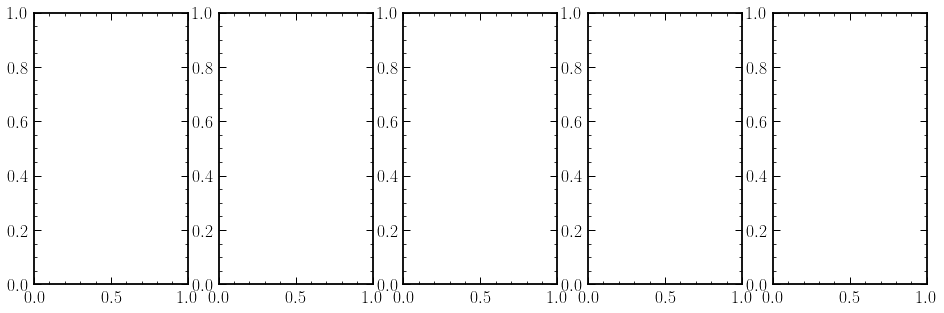

In [18]:
text_query = "barrred spiral galaxy"
text_query_tokenized = tokenizer([text_query], padding="max_length", truncation=True, max_length=77, return_tensors="np")
text_query_feat = model.get_text_features(**text_query_tokenized, params=restored_state.params)

# Get 4 closet images

sorted_test_idxs = np.argsort(jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_feat_stack), text_query_feat[0]))[::-1]

# Plot them

fig, ax = plt.subplots(1, 5, figsize=(16, 5))
for i in range(5):
    ax[i].imshow(get_image_from_stack(images_stack, sorted_test_idxs[i]))
    ax[i].axis('off')

plt.tight_layout()
# plt.savefig("../paper/plots/bsg.pdf", dpi=300)

In [23]:
# Get all cosine similarities
cos_sims = jax.vmap(cosine_similarity, in_axes=(0, None))(np.vstack(image_feat_stack), text_query_feat[0])

100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


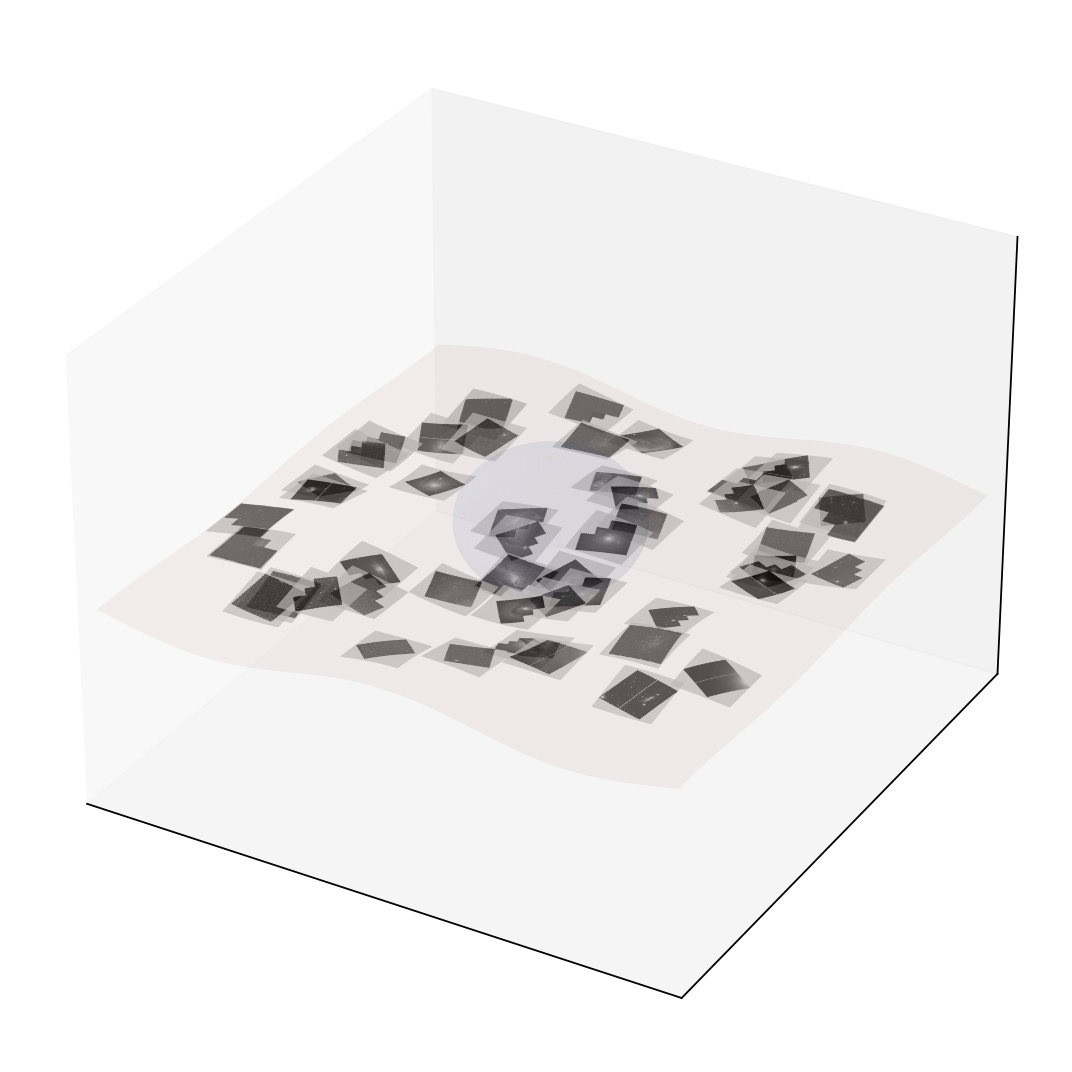

In [24]:
import numpy as onp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Generate grid points
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
x, y = np.meshgrid(x, y)

# Set the vertical separation distance
dx = 0.1
rnd = 0.04

# Define the 2D manifold equations for the top plane (blue)
z1 = np.sin(x) * np.cos(y) * rnd + dx

# Define the 2D manifold equations for the bottom plane (red)
z2 = np.cos(x) * np.sin(y) * rnd - dx

# Create a new figure and 3D axis
fig = plt.figure(figsize=(8 * 2.5, 6 * 2.5))
ax = fig.add_subplot(111, projection='3d')

# # Plot the top 2D manifold surface (blue)
# ax.plot_surface(x, y, z1, color='cornflowerblue', alpha=0.3, rstride=1, cstride=1, linewidth=0, antialiased=True, rasterized=True)

# Plot the bottom 2D manifold surface (red)
ax.plot_surface(x, y, z2, color='firebrick', alpha=0.05, rstride=1, cstride=1, linewidth=0, antialiased=True, rasterized=True)

# Plot the first 100 images on the firebrick surface

# Choose first 5 indices, then random sample 20 images from the rest
idxs_plots = list(sorted_test_idxs[:5]) + list(onp.random.choice(sorted_test_idxs[5:400], 45, replace=False))
for idx in tqdm(idxs_plots):


    img = get_image_from_stack(images_stack, idx)

    # Choose radius from (0, 0) depending on cosine similarity which is between [-1, 1]
    # Want those with larger cosine similarity to be closer to the center (smaller radius)
    # Cap the radius at 5
    # Add some randomness to the radius to avoid overlap
    radius = 6.5 * (1 - cos_sims[idx]) + onp.random.uniform(0.0, 0.2)

    # Randomly sample x and y positions so that image is at the radius
    theta = onp.random.uniform(0, 2 * onp.pi)
    xpos = radius * onp.cos(theta)
    ypos = radius * onp.sin(theta)

    dx_size = 0.5

    npiximg = 100

    # Make a small square around (xpos, ypos)
    x = np.linspace(xpos - dx_size, xpos + dx_size, npiximg)
    y = np.linspace(ypos - dx_size, ypos + dx_size, npiximg)

    x, y = np.meshgrid(x, y)

    # Creating a uniform Z surface for the image to lay on
    # z = np.zeros_like(x)
    
    # Put z along the manifold surface, slightly above the bottom surface
    z = np.cos(x) * np.sin(y) * rnd - dx
    
    # Scale image to be between 0 and 1 with sklearn MinMaxScaler
    img = img / img.max()
    img = img - img.min()

    # Downsample the image to 50x50 pixels via nearest neighbor interpolation
    from PIL import Image
    img = onp.array(img)
    img = Image.fromarray((img * 255).astype('uint8'))
    img = img.resize((npiximg, npiximg), Image.NEAREST)
    img = onp.array(img) / 255.

    # Plot the image
    ax.plot_surface(x, y, z, facecolors=img, rstride=1, cstride=1, linewidth=0, antialiased=True, rasterized=True)


# Plot a sphere around the origin
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 1.5 * np.outer(np.cos(u), np.sin(v))
y = 1.5 * np.outer(np.sin(u), np.sin(v))
z = 1.5 / (5 / 0.7) * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='cornflowerblue', alpha=0.05, rstride=1, cstride=1, linewidth=0, antialiased=True, rasterized=True)

# Remove the grid lines
ax.grid(False)

# Turn off axis labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Turn off ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-0.7, 0.7)

# # TUrn off the axis
# ax.axis('off')

# Set the background color to white
fig.patch.set_facecolor('white')

# Display the plot
plt.tight_layout()

# # Rasterize the 3D plot for better quality and save
# plt.savefig('../paper/plots/manifold_eval.pdf', bbox_inches='tight')

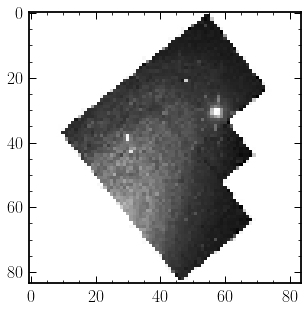

In [180]:
plt.imshow(onp.array(img))

100%|██████████| 65/65 [00:16<00:00,  3.94it/s]


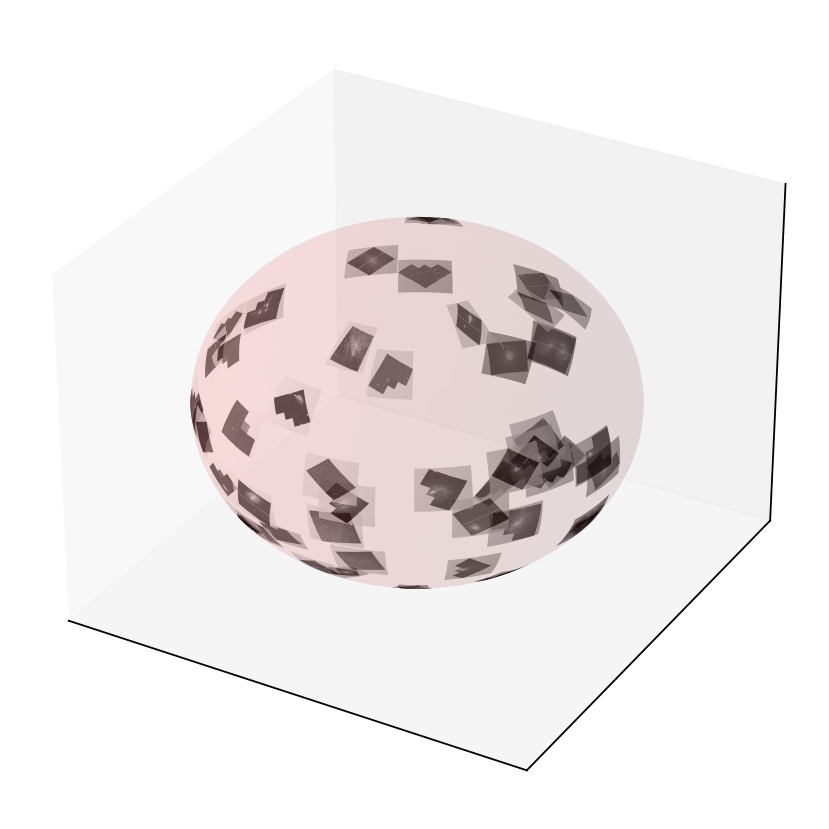

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate grid points more densely for a smoother surface
theta = np.linspace(0, np.pi, 100)  # From 0 to pi for a full sphere in the polar angle
phi = np.linspace(0, 2 * np.pi, 100)  # From 0 to 2pi for a full circle in the azimuthal angle
theta, phi = np.meshgrid(theta, phi)

# Sphere parameters
r = 4.5  # Radius for both spheres
dx = 0.2  # Offset in the x direction for the center of the first sphere
dy = 0.2  # Offset in the y direction for the center of the second sphere

# Sphere 2 center
x2_center, y2_center, z2_center = -dx, 0, 0  # Shift left

# Convert spherical coordinates to Cartesian coordinates for Sphere 2
x2 = x2_center + r * np.sin(theta) * np.cos(phi)
y2 = y2_center + r * np.sin(theta) * np.sin(phi)
z2 = z2_center + r * np.cos(theta)

# Plotting adjustments for equal-sized spheres
fig = plt.figure(figsize=(8 * 2.5, 6 * 2.5))
ax = fig.add_subplot(111, projection='3d')

# Plot Sphere 2 (Red)
ax.plot_surface(x2, y2, z2, color='red', alpha=0.06, linewidth=0)

# Choose first 5 indices, then random sample 20 images from the rest
idxs_plots = list(sorted_test_idxs[:5]) + list(onp.random.choice(sorted_test_idxs[5:400], 60, replace=False))
for idx in tqdm(idxs_plots):


    img = get_image_from_stack(images_stack, idx)

    radius = 6.5 * (1 - cos_sims[idx]) + onp.random.uniform(0.0, 0.2)
    
    npiximg = 100

    # Scale image to be between 0 and 1 with sklearn MinMaxScaler
    img = img / img.max()
    img = img - img.min()

    # Downsample the image to 50x50 pixels via nearest neighbor interpolation
    from PIL import Image
    img = onp.array(img)
    img = Image.fromarray((img * 255).astype('uint8'))
    img = img.resize((npiximg, npiximg), Image.NEAREST)
    img = onp.array(img) / 255.

    image_size = img.shape[0]  # Image resolution

    # theta_min, theta_max = np.pi/4, 3*np.pi/4  # Limit angles for the patch
    # phi_min, phi_max = np.pi/4, 3*np.pi/4

    # Choose a point on the sphere
    theta_center, phi_center = -np.pi / 2., -0.75 * np.pi / 4.  # Center of the patch

    # Randomly choose where to place image depending on radius
    # Radius is the physical distance between (theta_center, phi_center) and the image
    # Randomly sample theta_img and phi_img from a circle around (theta_center, phi_center) with radius `radius`
    theta_img = theta_center + 0.5 * radius ** 2. * np.sin(np.random.uniform(0, 2 * np.pi))
    phi_img = phi_center + 0.5 * radius ** 2. * np.cos(np.random.uniform(0, 2 * np.pi))

    # If near poles, ignore and continue
    theta_near_pole_threshold = np.radians(30.)  # 10 degrees in radians
    
    def normalize_theta(theta):
        # Ensure theta is within [0, 2π] to handle full wrap-around cases
        theta = theta % (2 * np.pi)

        if theta > np.pi:
            theta = 2 * np.pi - theta  # Reflect back into the [0, π] domain
        
        return theta

    theta_img = normalize_theta(theta_img)

    # Ensure theta_img is within the limits
    # Check if the image's center is near the poles
    if theta_img < theta_near_pole_threshold or theta_img > (np.pi - theta_near_pole_threshold):
        continue  # Skip this image placement due to proximity to the poles

    dsize = np.pi / 25  # Extent of the patch in radians

    # Scaling phi extent based on the cosine of theta_img to account for spherical distortion
    phi_extent_scaled = dsize / np.maximum(np.cos(theta_img), 0.1)  # Avoid division by zero near poles

    theta_min, theta_max = theta_img - dsize, theta_img + dsize
    phi_min, phi_max = phi_img - phi_extent_scaled, phi_img + phi_extent_scaled

    theta_min, theta_max = theta_img - dsize, theta_img + dsize
    phi_min, phi_max = phi_img - dsize, phi_img + dsize

    # Generate patch coordinates
    theta_patch, phi_patch = np.linspace(theta_min, theta_max, image_size), np.linspace(phi_min, phi_max, image_size)
    theta_patch, phi_patch = np.meshgrid(theta_patch, phi_patch)
    x_patch = x2_center + r * np.sin(theta_patch) * np.cos(phi_patch)
    y_patch = y2_center + r * np.sin(theta_patch) * np.sin(phi_patch)
    z_patch = z2_center + r * np.cos(theta_patch)

    # Plotting the image (or color patch) on the sphere
    ax.plot_surface(x_patch, y_patch, z_patch, facecolors=img, rstride=1, cstride=1, rasterized=True, linewidth=0, antialiased=True)

# View and limit adjustments
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_zlim([-5, 5])
ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])


plt.savefig('../paper/plots/manifold_eval.pdf', bbox_inches='tight')
